In [1]:
#Initialize and validate GPU on torch

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce GTX 1650 Ti


device(type='cuda', index=0)

# Task 1 - Faster RCNN

In [2]:
#Import necessary libraries

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

### Introduction to Faster R-CNN

Faster R-CNN is a significant improvement over its predecessors (R-CNN and Fast R-CNN) in both speed and accuracy.  
The key components include the Backbone (Feature Extractor), Region Proposal Network (RPN), RoI Pooling, and the final Detection head.

Region Proposal Network  
Proposal generation is an algorithm, such that given an image, provides the most probable locations of objects in that image. This is useful to narrow down the scope of the detection algorithms to few regions instead of every possible region (millions probably) in that image.  
The average proposal generation time in Fast RCNN was around 1.5s. This is very high since it used selective searching to compute the proposals.  
In Faster RCNN, we train a seperate network - Region Proposal Network (RPN) - which generates proposals of objects locations in an image.

How RPN works:  
1. Anchor generation - Anchors are predefined bounding boxes of different scales and aspect ratios. For each point in the iamge, multiple achros boxes are generated.  
2. Objectness score - When the image is passed through the layers of the RPN model, it provides an objectness score indicating the liheliness of the anchor being an object (forground) or not (background).  
3. Proposal Output - the RPN outputs a set of refined, high-confidence proposals, which are then passed to the subsequent RoI (Region of Interest) Pooling layer in Faster R-CNN for further classification and bounding box regression.

After RPN, the Fast RCNN methods are used to finally detect and localize the bounding boxes of the objects of interest. The further methods are:  
1. ROI Pooling - extracts fixed-size feature maps for each region proposal from the shared feature map.
2. Classification and Regression Head - Each fixed-size feature map is passed through a fully connected network to perform object classification for class label prediction and bounding box regression to further refine the coordinates of the bounding box.  
3. Non-Maximum Suppression - eliminates redundant boxes with high overlap, keeping only the most confident ones.  
4. Output - The model outputs the final bounding boxes with class labels for each detected object.

The following cells will demonstrate the bounding box detection of a pretrained model for a soccer video.  
The below function loads the pretrained pytorch model for faster RCNN trained on the COCO dataset.

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Loading and Preprocessing Data

This code will read the soccer video and store the frames

In [13]:
# Store all the frames of the video here
images = []

#Opencv reads the video frame by frame
cap = cv2.VideoCapture('football_video.mp4')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        #Convert the image to the required format and append to images list
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (640, 360))
        images.append(img)
    else:
        break

cap.release()

There are 1074 frames in the video, each having a dimension of 360, 640 with 3 color channels

In [14]:
np.shape(images)

(1074, 360, 640, 3)

The below function is a helper function to draw bounding boxes around the image if the confidence is more than the required threshold.
Our classes of interest include:  
1. Person (label 1)
2. Sports Ball (label 37)

In [15]:
def draw_bounding_boxes(image, boxes, labels, scores, threshold=0.5):
    for i, box in enumerate(boxes):
        # Check if score is above threshold and the label belongs to our classes of interest
        if scores[i] >= threshold and (labels[i] == 1 or labels[i] == 37):
            x1, y1, x2, y2 = map(int, box)
            label = 'person' if labels[i] == 1 else 'sports ball'
            color = (0, 255, 0) if label == 'person' else (0, 0, 255)

            #Draw bounding box around the object of interest and label it
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f'{label}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    #Return image with bounding boxes
    return image

The below function performs inference across all the images and draws the bounding boxes on the detected objects.  
These images are stored in a list

In [26]:
from tqdm import tqdm

output_images = []

for frame in tqdm(images):
    #Convert numpy image to pytorch tensor
    image_tensor = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    #Perform forward pass
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    #Retrieve the box coordinates, object labels, and confidence scores
    boxes = predictions['boxes'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()

    #Draw bounding box for objects of interest with confidence above 50% and store the image
    frame = draw_bounding_boxes(frame, boxes, labels, scores, threshold=0.5)
    output_images.append(frame)

    #Free the memory
    del boxes, labels, scores, predictions, image_tensor

100%|██████████| 1074/1074 [23:37<00:00,  1.32s/it]


### Visualization of Processed frames by Faster RCNN

The processed frames are also being stored in the form of a video

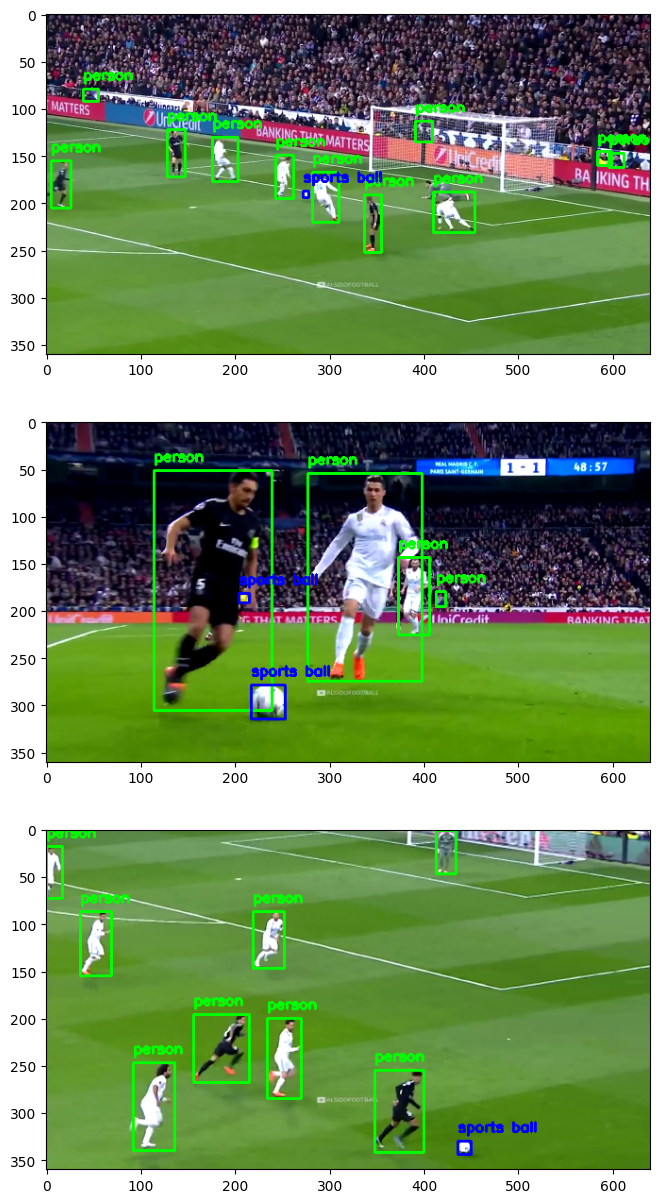

In [62]:
#Display sample images
fig, axs = plt.subplots(3, figsize=(15, 15))
axs[0].imshow(output_images[323])
axs[1].imshow(output_images[135])
_ = axs[2].imshow(output_images[710])

In [43]:
#Store all the frames in a video
out = cv2.VideoWriter("faster_rcnn_output_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (640, 360))
for image in output_images:
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    out.write(img)
out.release()

### Conclusion of Faster RCNN
From the above demonstration, it is clear that Faster RCNN is a good object detection model.  
Hence, we will continue using this model for the Deep Sort demonstration below

# Task 2 - Deep-SORT

### Introduction to DeepSort

DeepSort (Simple Online and Realtime Tracking with a Deep Association Metric) is a tracking algorithm that appends deep learning to the SORT algorithm. This allows us to track objects in a video along with their specific IDs.  

The main components of the algorithm are:  
1. Detection Module - This module takes an image as input, and produces the bounding box coordinates for the detected objects along with the confidence score. As part of the below example, we are going to be using the above trained Faster RCNN object detection model in this module.  
2. Deep Appearance Descriptor - This module takes the detected objects cropped form the image (cropping is done though bounding box coordinates) and converting this image into a feature descriptor. This conversion process is done by passing the image through a pretrained feature extractor model such as the Resnet50 used below. This helps to maintain the identity of the objects when motion predictor fails.
3. Kalman Filter - The Kalman Filter is used to predict the position of objects between frames based on their previous state. It tracks an object’s position, velocity, and size (height and width). A detailed explanation of the Kalman filter is done below.
4. Hungarian Algorithm - This algorithm helps to assign the detections across frames to a specific object to achieve object tracking. It minimizes the assignment cost to $O(n^3)$. In DeepSORT, it matches predicted track states with new detections based on a cost matrix. The cost matrix C can be computed using various metrics such as IoU (used below), Mahalanobis Distance, etc. If a track or detection remains unmatched, the algorithm either marks it as a potential new track or an old track to be removed if it remains unmatched over several frames.
5. Track Management - This module manages the tracks by updating the state of each track (i.e., position and velocity) based on the associated objects and their appearance features. It also handles removal of tracks that have not been associated with any objects for a certain number of frames or that have low confidence scores.

![Deepsort Architecture](deepsort_architecture.png "Deepsort Architecture")

In [ ]:
#Import necessary libraries

import torch
import torchvision
import cv2
import numpy as np
from torchvision.transforms import functional as F
from collections import deque
from scipy.spatial import distance
import torchvision.transforms as transforms
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

Intersection of Union Algorithm

This algorithm calculates the ratio of the common area between two rectangle boxes to the total area across both boxes.  
Area 1 = Area of Box 1  
Area 2 = Area of Box 2  

Intersection = area of inner rectangle formed by overlap  
Union = Area 1 + Area 2 - Intersection  

IOU = Intersection / Union

In [42]:
#Calculate intersection over union between two boxes.
def calculate_iou(box1, box2):
    #Extract box ccordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    #Compute union area, and intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    #Return 0 if no union, else return IoU ratio
    return intersection / union if union > 0 else 0

Non Max Suppression  

This method combines multiple overlapping boxes over one object into a single (most confident) bounding box.  
This reduces multiple bounding boxes around a person or ball to a single one.

Step 1: For multiple boxes, calculate the overlap  
Step 2: If overlap > threshold, then remove all less confident boxes  
Step 3: Return the box list

In [ ]:
#Convert a set of detections to remove overlapping detections and return the processed detections list
def nms_detections(detections, scores, nms_threshold=0.3):
    if len(detections) == 0:
        return [], []

    # Convert to numpy array for easier processing
    boxes = np.array(detections)
    scores = np.array(scores)

    # Calculate areas for all boxes
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # Sort boxes by confidence score instead of y-coordinate
    idxs = np.argsort(scores)

    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the intersection
        xx1 = np.maximum(boxes[i, 0], boxes[idxs[:last], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[idxs[:last], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[idxs[:last], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[idxs[:last], 3])

        # Calculate intersection area
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        intersection = w * h

        # Calculate IoU
        overlap = intersection / (areas[i] + areas[idxs[:last]] - intersection)

        # Delete all indexes from the index list that have IoU greater than threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > nms_threshold)[0])))

    return [detections[i] for i in pick], [scores[i] for i in pick]

ResNet50 Feature extractor for performing Deep Appearance Feature Extraction in Deep-SORT  
This class takes an image and generates the features for that image by passing it through the resnet model.

In [ ]:
#Deep Appearance Feature Extraction

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Use ResNet50 backbone pre-trained on ImageNet
        resnet = torchvision.models.resnet50(pretrained=True)
        # Remove the last fully connected layer and pool5
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # L2 normalization
        x = x / torch.norm(x, p=2, dim=1, keepdim=True)
        return x

Track Management  

The Tracker class manages the tracked objects, assigns track IDs, and updates the state of the objects using the Kalman filter. For unmatched detections, new tracks are created.  
Each component in the tracker class is explained below:

### Kalman Filter
This function initializes the kalman filter object with a set of parameters.  

To understand these assignments, we need to understand the equations used by the filter. These are provided below:  

#### State Vector -  
The Kalman filter maintains an 8 dimensional state vector :  
$\mathbf{x} = \left[ u, v, s, r, \dot{u}, \dot{v}, \dot{s} \right]^T$  

Where:  
- (u, v): Center coordinates of the bounding box.
- (s): Scale (area of the bounding box).
- (r): Aspect ratio (width/height).
- $(\dot{u}, \dot{v}, \dot{s})$: Velocities of center coordinates and scale.  


#### State Transition Model -  
The state transition model describes how the state evolves over time, assuming linear motion. The predicted state $(\mathbf{x}_{k|k-1})$ at time step k is given by:  
$\mathbf{x}_{k|k-1} = \mathbf{F} \mathbf{x}_{k-1|k-1} + \mathbf{B} \mathbf{u}_{k} + \mathbf{w}_{k}$  

Where:  
- $(\mathbf{F})$: State transition matrix.
- $(\mathbf{B})$: Control matrix (not used in DeepSORT, so typically omitted).
- $(\mathbf{u}_{k})$: Control input (assumed to be zero in this context).
- $(\mathbf{w}_{k})$: Process noise, assumed to be Gaussian with covariance $(\mathbf{Q})$.

The covariance update equation is: $\mathbf{P}_{k|k-1} = \mathbf{F} \mathbf{P}_{k-1|k-1} \mathbf{F}^T + \mathbf{Q}$


#### Measurement Model -  
The measurement model maps the state vector to the observed measurements. The measurement $(\mathbf{z}_{k})$ at time step k is given by:  
$\mathbf{z}_{k} = \mathbf{H} \mathbf{x}_{k} + \mathbf{v}_{k}$  

Where:  
- $(\mathbf{H})$: Observation matrix, which selects the observable components of the state vector.
- $(\mathbf{v}_{k})$: Measurement noise, assumed to be Gaussian with covariance $(\mathbf{R})$.

#### Kalman Filter Equations
The Kalman Filter update consists of two main steps:  

**1. Prediction Step:**  

$\hat{\mathbf{x}}_{k|k-1} = \mathbf{F} \hat{\mathbf{x}}_{k-1|k-1}$  
$\mathbf{P}_{k|k-1} = \mathbf{F} \mathbf{P}_{k-1|k-1} \mathbf{F}^T + \mathbf{Q}$  

**2. Update Step:**  

The Kalman gain \(\mathbf{K}\) is computed as:  

$\mathbf{K}_{k} = \mathbf{P}_{k|k-1} \mathbf{H}^T (\mathbf{H}$  
$\mathbf{P}_{k|k-1} \mathbf{H}^T + \mathbf{R})^{-1}$  

The state vector and covariance matrix are updated as:  
$\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_{k} \left(\mathbf{z}_{k} - \mathbf{H} \hat{\mathbf{x}}_{k|k-1}\right)$  
$\mathbf{P}_{k|k} = \left(\mathbf{I} - \mathbf{K}_{k} \mathbf{H}\right) \mathbf{P}_{k|k-1}$  

### Hungarian Algorithm

In the update step of Kalman filter, it calls the hungarian algorithm to compute the cosine similarity across features and the IOU across detections to determine if the detections are matched or unmatched.  
The Hungarian Algorithm then finds the optimal assignment with the minimum total cost, ensuring each detection is matched to at most one track and vice versa.  

#### Steps of the Hungarian Algorithm:
1. **Compute Cost Matrix**: Calculate the cost matrix C between predicted tracks and current detections. The cost in this case is the IoU, and hence C is the IoU matrix.
2. **Apply Algorithm**: Use the Hungarian Algorithm to find the optimal assignment that minimizes the total cost.
3. **Handle Unmatched Tracks and Detections**: If a track or detection remains unmatched, the algorithm either marks it as a potential new track or an old track to be removed if it remains unmatched over several frames.


In [94]:
class Tracker:
    def __init__(self):
        #Track management variables
        self.tracks = {}
        self.track_id = 0

        # How much frames to wait until the track is deleted
        self.max_disappeared = 3

        #ResNet50 extractor
        self.feature_extractor = FeatureExtractor().to(device)
        self.feature_extractor.eval()

        self.min_confidence = 0.3
        self.max_cosine_distance = 0.3

        #Image transformation for feature extractor based on the hardcoded mean and std
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    #Create the Kalman filters with the standard parameters
    def initialize_kf(self):
        kf = KalmanFilter(dim_x=7, dim_z=4)  # State: [x, y, w, h, vx, vy, s]

        # State transition matrix
        kf.F = np.array([[1, 0, 0, 0, 1, 0, 0],  # x = x + vx
                        [0, 1, 0, 0, 0, 1, 0],  # y = y + vy
                        [0, 0, 1, 0, 0, 0, 0],  # w = w
                        [0, 0, 0, 1, 0, 0, 0],  # h = h
                        [0, 0, 0, 0, 1, 0, 0],  # vx = vx
                        [0, 0, 0, 0, 0, 1, 0],  # vy = vy
                        [0, 0, 0, 0, 0, 0, 1]]) # s = s

        # Measurement matrix
        kf.H = np.array([[1, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0]])

        kf.R = np.eye(4) * 100  # Measurement noise
        kf.Q = np.eye(7) * 1.0  # Process noise
        kf.P = np.eye(7) * 1000  # Covariance matrix

        return kf

    #Extract deep features from detection bbox.
    def extract_features(self, frame, bbox):
        x1, y1, x2, y2 = map(int, bbox)
        if x1 < 0:
            x1 = 0
        if y1 < 0:
            y1 = 0
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            return np.zeros((2048,))

        # Transform the cropped image
        img_tensor = self.transform(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            features = self.feature_extractor(img_tensor)
        return features.cpu().numpy().flatten()

    #Calculate cosine distance between feature vectors.
    def cosine_distance(self, features1, features2):
        return 1 - np.dot(features1, features2) / (
            np.linalg.norm(features1) * np.linalg.norm(features2))

    # Perform Hungarian algorithm matching
    def match_detections(self, tracks, detections, frame, threshold=0.5):
        if len(tracks) == 0 or len(detections) == 0:
            return [], list(range(len(tracks))), list(range(len(detections)))

        iou_matrix = np.zeros((len(tracks), len(detections)))
        feature_matrix = np.zeros((len(tracks), len(detections)))
        detection_features = []

        # Extract features for all detections
        for detection in detections:
            features = self.extract_features(frame, detection)
            detection_features.append(features)

        # Calculate both IoU and feature distance matrices for all tracks
        track_ids = list(self.tracks.keys())
        for t, track_id in enumerate(track_ids):
            track = self.tracks[track_id]
            for d, detection in enumerate(detections):
                iou_matrix[t, d] = calculate_iou(track['bbox'], detection)
                feature_matrix[t, d] = self.cosine_distance(
                    track['features'], detection_features[d])

        # Combine IoU and feature distances
        distance_matrix = (1 - iou_matrix) * 0.5 + feature_matrix * 0.5
        track_indices, detection_indices = linear_sum_assignment(distance_matrix)

        matched = []
        unmatched_tracks = []
        unmatched_detections = list(range(len(detections)))

        # Based on the threshold, compute the matched and unmatched tracks
        for track_idx, det_idx in zip(track_indices, detection_indices):
            if (distance_matrix[track_idx, det_idx] <= threshold and
                feature_matrix[track_idx, det_idx] <= self.max_cosine_distance):
                matched.append((track_idx, det_idx))
                if det_idx in unmatched_detections:
                    unmatched_detections.remove(det_idx)
            else:
                unmatched_tracks.append(track_idx)

        # Add unmatched tracks
        for i in range(len(tracks)):
            if i not in track_indices:
                unmatched_tracks.append(i)

        return matched, unmatched_tracks, unmatched_detections

    # kalman Filter update step
    def update(self, detections, frame):
        # Initialize tracks if empty
        if len(self.tracks) == 0:
            for det in detections:
                features = self.extract_features(frame, det)
                self.tracks[self.track_id] = {
                    'bbox': det,
                    'kf': self.initialize_kf(),
                    'features': features,
                    'disappeared': 0
                }
                z = self.bbox_to_z(det)
                self.tracks[self.track_id]['kf'].x[:4] = z.reshape((4, 1))
                self.track_id += 1
            return self.tracks

        # Predict new locations of existing tracks
        predicted_tracks = []
        for track_id, track in self.tracks.items():
            track['kf'].predict()
            predicted_bbox = self.z_to_bbox(track['kf'].x[:4])
            predicted_tracks.append(predicted_bbox)

        # Match detections to tracks using both IoU and feature similarity
        matched, unmatched_tracks, unmatched_detections = self.match_detections(
            predicted_tracks, detections, frame)

        # Update matched tracks, disappeared is if the object is not detected in the next frame
        for track_idx, det_idx in matched:
            if track_idx < len(self.tracks):
                track_id = list(self.tracks.keys())[track_idx]
                z = self.bbox_to_z(detections[det_idx])
                self.tracks[track_id]['kf'].update(z)
                self.tracks[track_id]['bbox'] = self.z_to_bbox(self.tracks[track_id]['kf'].x[:4])
                self.tracks[track_id]['features'] = self.extract_features(frame, detections[det_idx])
                self.tracks[track_id]['disappeared'] = 0

        # Update unmatched tracks, remove disappeared tracks for more than 'max_disappeared' frames
        track_ids = list(self.tracks.keys())
        for idx in unmatched_tracks:
            if idx < len(track_ids):
                track_id = track_ids[idx]
                self.tracks[track_id]['disappeared'] += 1
                self.tracks[track_id]['bbox'] = self.z_to_bbox(self.tracks[track_id]['kf'].x[:4])
                if self.tracks[track_id]['disappeared'] > self.max_disappeared:
                    del self.tracks[track_id]

        # Create new tracks for unmatched detections
        for idx in unmatched_detections:
            features = self.extract_features(frame, detections[idx])
            self.tracks[self.track_id] = {
                'bbox': detections[idx],
                'kf': self.initialize_kf(),
                'features': features,
                'disappeared': 0
            }
            z = self.bbox_to_z(detections[idx])
            self.tracks[self.track_id]['kf'].x[:4] = z.reshape((4, 1))
            self.track_id += 1

        return self.tracks

    #Convert bounding box to measurement vector [x, y, w, h].
    def bbox_to_z(self, bbox):
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        x = bbox[0] + w/2
        y = bbox[1] + h/2
        return np.array([x, y, w, h]).reshape((4, 1))

    #Convert measurement vector [x, y, w, h] to bounding box [x1, y1, x2, y2].
    def z_to_bbox(self, z):
        x, y, w, h = z.flatten()
        x1 = x - w/2
        x2 = x + w/2
        y1 = y - h/2
        y2 = y + h/2
        return [int(x1), int(y1), int(x2), int(y2)]

The below function implements the above algorithms on a football video. The steps are:  

Step 1: Implement object detection using the above model  
Step 2: Perform Non Max Supression  
Step 3: Perform temporal filtering to remove detections that are very far from exissting tracks  
Step 4: Add the detections to Kalman filter update track  
Step 5: Draw bounding boxes based on the Kalman filter smoothed outputs  

In [ ]:
def detect_and_track(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    tracker = Tracker()

    tracker.max_disappeared = 3
    tracker.min_confidence = 0.6
    tracker.max_cosine_distance = 0.2

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        image = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            predictions = model(image)[0]

        boxes = predictions['boxes'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()

        # Filter detections with higher confidence threshold
        detections = []
        detection_scores = []
        for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
            # Increase confidence threshold
            if ((label == 1 and score > 0.90) or  # Person detection threshold
                (label == 37 and score > 0.95)):  # Sports ball threshold
                x1, y1, x2, y2 = map(int, box)

                # Add minimum size threshold
                w = x2 - x1
                h = y2 - y1
                if w * h > 100:  # Minimum area threshold
                    detections.append([x1, y1, x2, y2])
                    detection_scores.append(score)

        # Apply NMS with scores
        if detections:
            detections, _ = nms_detections(detections, detection_scores, nms_threshold=0.3)

        # Update tracks with temporal filtering
        if len(tracker.tracks) > 0:
            # Apply motion-based filtering
            current_tracks = list(tracker.tracks.values())
            for det in detections[:]:
                valid_detection = True
                for track in current_tracks:
                    track_box = track['bbox']
                    # Check if detection is too far from existing tracks
                    iou = calculate_iou(det, track_box)
                    if iou > 0.1:  # If there's some overlap
                        dx = abs((det[0] + det[2])/2 - (track_box[0] + track_box[2])/2)
                        dy = abs((det[1] + det[3])/2 - (track_box[1] + track_box[3])/2)
                        if dx > 100 or dy > 100:  # Too much movement between frames
                            valid_detection = False
                            break
                if not valid_detection:
                    detections.remove(det)

        tracked_objects = tracker.update(detections, frame)

        # Visualization with track smoothing
        for track_id, track in tracked_objects.items():
            if isinstance(track['bbox'], (list, np.ndarray)) and len(track['bbox']) == 4:
                x1, y1, x2, y2 = map(int, track['bbox'])
                # Add box size verification
                w = x2 - x1
                h = y2 - y1
                if w * h > 100:  # Minimum area threshold
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        out.write(frame)
        # output_frames.append(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
video_path = "football_video.mp4"
output_path = "deepsort_output_video.mp4"
detect_and_track(video_path, output_path)

### Vizualization of Deep-SORT object tracking

In [ ]:
# Open the video file
video_path = 'deepsort_output_video.mp4'
cap = cv2.VideoCapture(video_path)

images = []
# Loop through and display the images
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        # Convert the frame from BGR (OpenCV format) to RGB (Matplotlib format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        images.append(frame_rgb)
    else:
        break

cap.release()

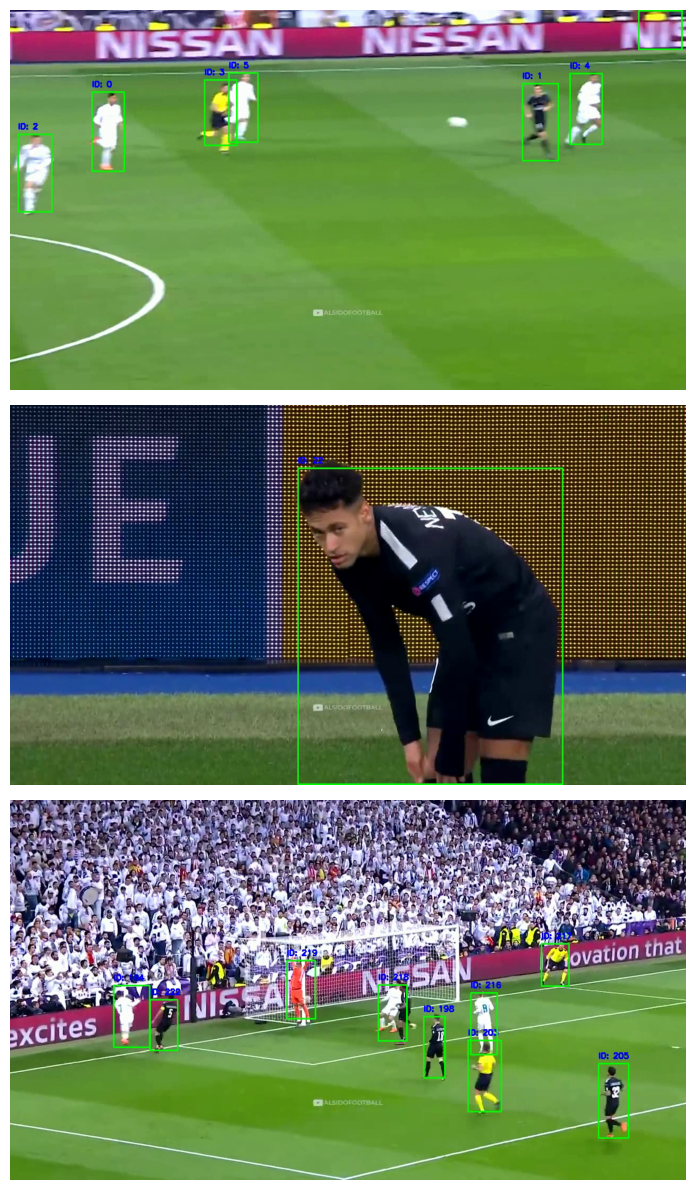

In [120]:
idx = [2, 105, 976]
plt.figure(figsize=(15, 12))
for i, id in enumerate(idx):
    # Plot the image
    plt.subplot(3, 1, i + 1)
    plt.imshow(images[id])
    plt.axis('off')  # Hide axes

# Display the images
plt.tight_layout()
plt.show()

### Conclusion
The combination of Kalman Filter for motion prediction and the Hungarian Algorithm for data association, along with a deep appearance feature extractor, allows DeepSORT to achieve robust and accurate multi-object tracking.  
The above demonstration shows that this algorithm is able to accurately track players and the soccer ball efficiently